In [1]:

import os 
import numpy as np
import torch
import torch.nn as nn 
import random
import matplotlib.pyplot as plt 
import skimage 
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio
from tqdm import tqdm
import wandb
from deepinv.physics import Tomography, Downsampling

from torch.func import jvp, functional_call, jacrev

from operator_module import OperatorModule

from model.unet import get_unet_model



In [4]:
cfg = {
    "forward_operator": "radon",  #"downsampling", # "radon"
    "lr": 1e-4,
    "num_angles": 90,
    "rel_noise": 0.05,
    "num_epochs": 10000,
    "img_log_freq": 100,
    "model_params": {
        "use_norm": False,
        "scales": 5,
        "use_sigmoid": False,
        "skip": 0,
        "channels": (32, 64, 128, 128, 256, 256),
        "activation" : "relu" # "silu"
    },
    "model_inp": "random", # "random" "fbp"
    "inp_noise": 0.05,
    "optimiser": "adam", # "lbfgs" "adam" "gd" #amsgrad # "rmsprop"
    "betas": (0.9, 0.999),
    "momentum" : 0.0,
    "weight_decay": 0.0,
    "tv_reg": 4e-4
    ,
    "tv_type": "anisotropic"
}

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv4_b = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv1u = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv2u = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3u = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4u = nn.Conv2d(128, 1, kernel_size=1)  

        self.relu = nn.ReLU(inplace=True)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    
    def forward(self, x):
        
        # Encoder
        x = self.relu(self.conv1(x))     # conv1 + relu1
        x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)   # 64x64

        x = self.relu(self.conv2(x))     # conv2 + relu2
        x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)  # 32x32

        x = self.relu(self.conv3(x))     # conv3 + relu3
        x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)   # 16x16

        x = self.relu(self.conv4(x))     # conv4 + relu4
        x = self.relu(self.conv4_b(x))   # conv4

        # Decoder
        x = F.interpolate(x, scale_factor=2.0, mode='bilinear', align_corners=False)  # 32x32
        x = self.relu(self.conv1u(x))    # conv1 + relu5

        x = F.interpolate(x, scale_factor=2.0, mode='bilinear', align_corners=False)  # 64x64
        x = self.relu(self.conv2u(x))    # conv2 + relu6

        x = F.interpolate(x, scale_factor=2.0, mode='bilinear', align_corners=False) # 128x128
        x = self.relu(self.conv3u(x))    # conv3 + relu7

        x = self.conv4u(x)               # conv4
        return x


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4_b = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)  # concat with conv3 output
        self.upconv2 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)  # concat with conv2 output
        self.upconv3 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)  # concat with conv1 output
        self.final_conv = nn.Conv2d(128, 1, kernel_size=1)  # final RGB output

        self.relu = nn.ReLU(inplace=True)

        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    
    def forward(self, x):
        # Encoder
        x1 = self.relu(self.conv1(x))  # convd1 + relu1
        x1_down = F.interpolate(x1, scale_factor=0.5, mode='bilinear', align_corners=False)  # down1

        x2 = self.relu(self.conv2(x1_down))  # convd2 + relu2
        x2_down = F.interpolate(x2, scale_factor=0.5, mode='bilinear', align_corners=False)  # down2

        x3 = self.relu(self.conv3(x2_down))  # convd3 + relu3
        x3_down = F.interpolate(x3, scale_factor=0.5, mode='bilinear', align_corners=False)  # down3

        x4 = self.relu(self.conv4(x3_down))  # convd4 + relu4
        x4 = self.relu(self.conv4_b(x4))     # conv4

        # Decoder
        x_up1 = F.interpolate(x4, scale_factor=2.0, mode='bilinear', align_corners=False)  # up1
        x_up1 = self.relu(self.upconv1(torch.cat([x_up1, x3], dim=1)))  # skip connection from x3

        x_up2 = F.interpolate(x_up1, scale_factor=2.0, mode='bilinear', align_corners=False)  # up2
        x_up2 = self.relu(self.upconv2(torch.cat([x_up2, x2], dim=1)))  # skip connection from x2

        x_up3 = F.interpolate(x_up2, scale_factor=2.0, mode='bilinear', align_corners=False)  # up3
        x_up3 = self.relu(self.upconv3(torch.cat([x_up3, x1], dim=1)))  # skip connection from x1

        out = self.final_conv(x_up3)  # convu4
        return out


In [9]:
device = "cuda"
x = torch.load("walnut.pt")
x = x.float().to(device)

x = torch.nn.functional.interpolate(x, size=(128,128))

In [25]:

#device = "cuda:1"
device = "cuda"
# If I set torch.manuel_seed it is still random 
torch.manual_seed(2)

#model = get_unet_model(use_norm=cfg["model_params"]["use_norm"], 
#                        scales=cfg["model_params"]["scales"],
#                        use_sigmoid=cfg["model_params"]["use_sigmoid"], 
#                        skip=cfg["model_params"]["skip"],
#                        channels=cfg["model_params"]["channels"])
model = UNet() #Autoencoder()
#model.load_state_dict(torch.load("UNet_steps=1000.pt"))


model.to(device)

x = torch.load("walnut.pt")
x = x.float().to(device)

x = torch.nn.functional.interpolate(x, size=(128,128))

print("x: ", x.shape)

A = Tomography(angles=cfg["num_angles"], img_width=128, device=device) 
A = OperatorModule(A)

y = A(x)
print("noise std: ", cfg["rel_noise"]*torch.mean(y.abs()))
y_noise = y + cfg["rel_noise"]*torch.mean(y.abs())*torch.randn_like(y)
x_fbp = A.A_dagger(y_noise) 
print(y.shape, y_noise.shape)

print("Number of parameters: ", sum([p.numel() for p in model.parameters()]))
if cfg["model_inp"] == "fbp":
    z = x_fbp
else:
    z = 0.1 * torch.randn(x.shape)

z = z.to(device)
y_noise = y_noise.to(device)

with torch.no_grad():
    x_pred = model(z)


x:  torch.Size([1, 1, 128, 128])
noise std:  tensor(0.4528, device='cuda:0')
torch.Size([1, 1, 182, 90]) torch.Size([1, 1, 182, 90])
Number of parameters:  1476865


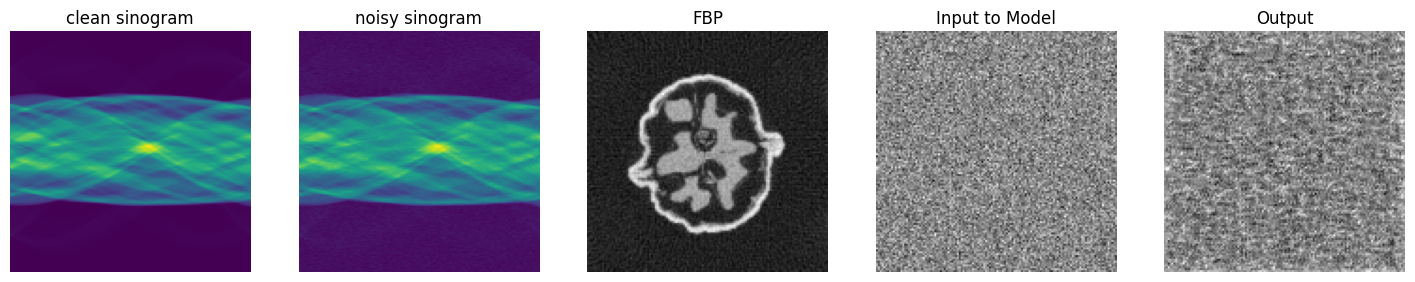

In [26]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(18,6))

ax1.imshow(y[0,0,:,:].cpu().numpy())
ax1.set_title("clean sinogram")
ax1.axis("off")
ax1.set_aspect(y.shape[-1] / y.shape[-2]) 

ax2.imshow(y_noise[0,0,:,:].cpu().numpy())
ax2.set_title("noisy sinogram")
ax2.axis("off")
ax2.set_aspect(y.shape[-1] / y.shape[-2]) 

ax3.imshow(x_fbp[0,0,:,:].cpu().numpy(), cmap="gray")
ax3.set_title("FBP")
ax3.axis("off")

ax4.imshow(z[0,0,:,:].cpu().numpy(), cmap="gray")
ax4.set_title("Input to Model")
ax4.axis("off")

ax5.imshow(x_pred[0,0,:,:].cpu().numpy(), cmap="gray")
ax5.set_title("Output")
ax5.axis("off")


plt.show()


In [27]:
# get only some rows of the jacobian 

import torch
from torch.func import vjp, functional_call

def model_forward(theta):
    return functional_call(model, theta, z)

def get_jacobian_col(col_index):
    
    out, vjp_fun = vjp(model_forward, theta_0)

    v = torch.zeros_like(x).ravel()
    v[col_index] = 1.0 
    v = v.reshape(*x.shape)
    jac_col = vjp_fun(v)[0] # this should get me J.T v 

    out, jvp_out = jvp(model_forward, (theta_0,), (jac_col,)) # this should get me J J.T v
    
    return jvp_out.detach()
    


In [28]:
theta_0 = dict(model.named_parameters())


In [29]:
num_rows = int(0.05 * np.prod(x.shape))
print("Number of rows: ", num_rows)
rows_idx = np.random.choice(np.prod(x.shape), num_rows, replace=False)
rows_idx = np.sort(rows_idx)
#print(rows_idx)

jac_approx = [] 

for row_idx in tqdm(rows_idx):
    jac_row = get_jacobian_col(row_idx)
    jac_approx.append(jac_row.ravel())    

jac_approx = torch.stack(jac_approx, dim=-1)
print("jac approx: ", jac_approx.shape)

Number of rows:  819


100%|██████████| 819/819 [00:02<00:00, 293.90it/s]

jac approx:  torch.Size([16384, 819])


In [30]:
Q, R = torch.linalg.qr(jac_approx)

In [31]:
print(Q.shape, R.shape)

torch.Size([16384, 819]) torch.Size([819, 819])


In [32]:
# get only some rows of the jacobian 

import torch
from torch.func import vjp, functional_call

def model_forward(theta):
    return functional_call(model, theta, z)

def get_K_vec(v):
    
    out, vjp_fun = vjp(model_forward, theta_0)

    v = v.reshape(*x.shape)
    jac_col = vjp_fun(v)[0] # this should get me J.T v 

    out, jvp_out = jvp(model_forward, (theta_0,), (jac_col,)) # this should get me J J.T v
    
    return jvp_out.detach()
    


In [33]:

KQ_ = [] 

for i in tqdm(range(Q.shape[-1])):
    jac_row = get_K_vec(Q[:,i])
    KQ_.append(jac_row.ravel())    

KQ = torch.stack(KQ_, dim=-1)
print("KQ: ", KQ.shape)

100%|██████████| 819/819 [00:02<00:00, 311.46it/s]

KQ:  torch.Size([16384, 819])


In [34]:
B = Q.T @ KQ

In [35]:
U_B, S_B, Vh_B = torch.linalg.svd(B)

print(U_B.shape, S_B.shape, Vh_B.shape)


torch.Size([819, 819]) torch.Size([819]) torch.Size([819, 819])


In [36]:
U_approx = Q @ U_B

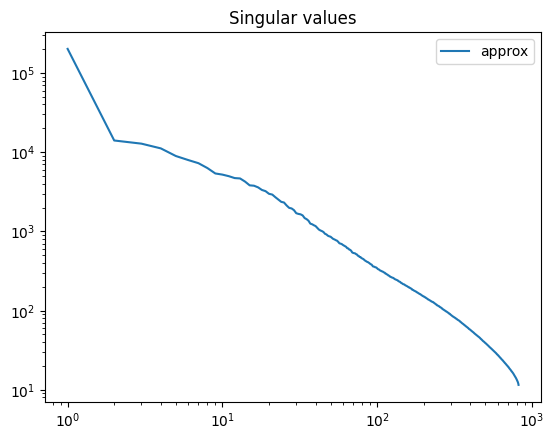

In [37]:
plt.figure()
plt.title("Singular values")
#plt.loglog(np.arange(1, len(S)+1), S.detach().cpu().numpy()**2, label="orig")
plt.loglog(np.arange(1, len(S_B)+1), S_B.detach().cpu().numpy(), label="approx")
plt.legend()
plt.show()

In [330]:
S_B[0:10]

tensor([421727.6250,  26935.4082,  15583.1396,  13775.7842,   7925.6963,
          5685.3945,   3820.8174,   3322.1565,   2590.4060,   2357.2520],
       device='cuda:1')

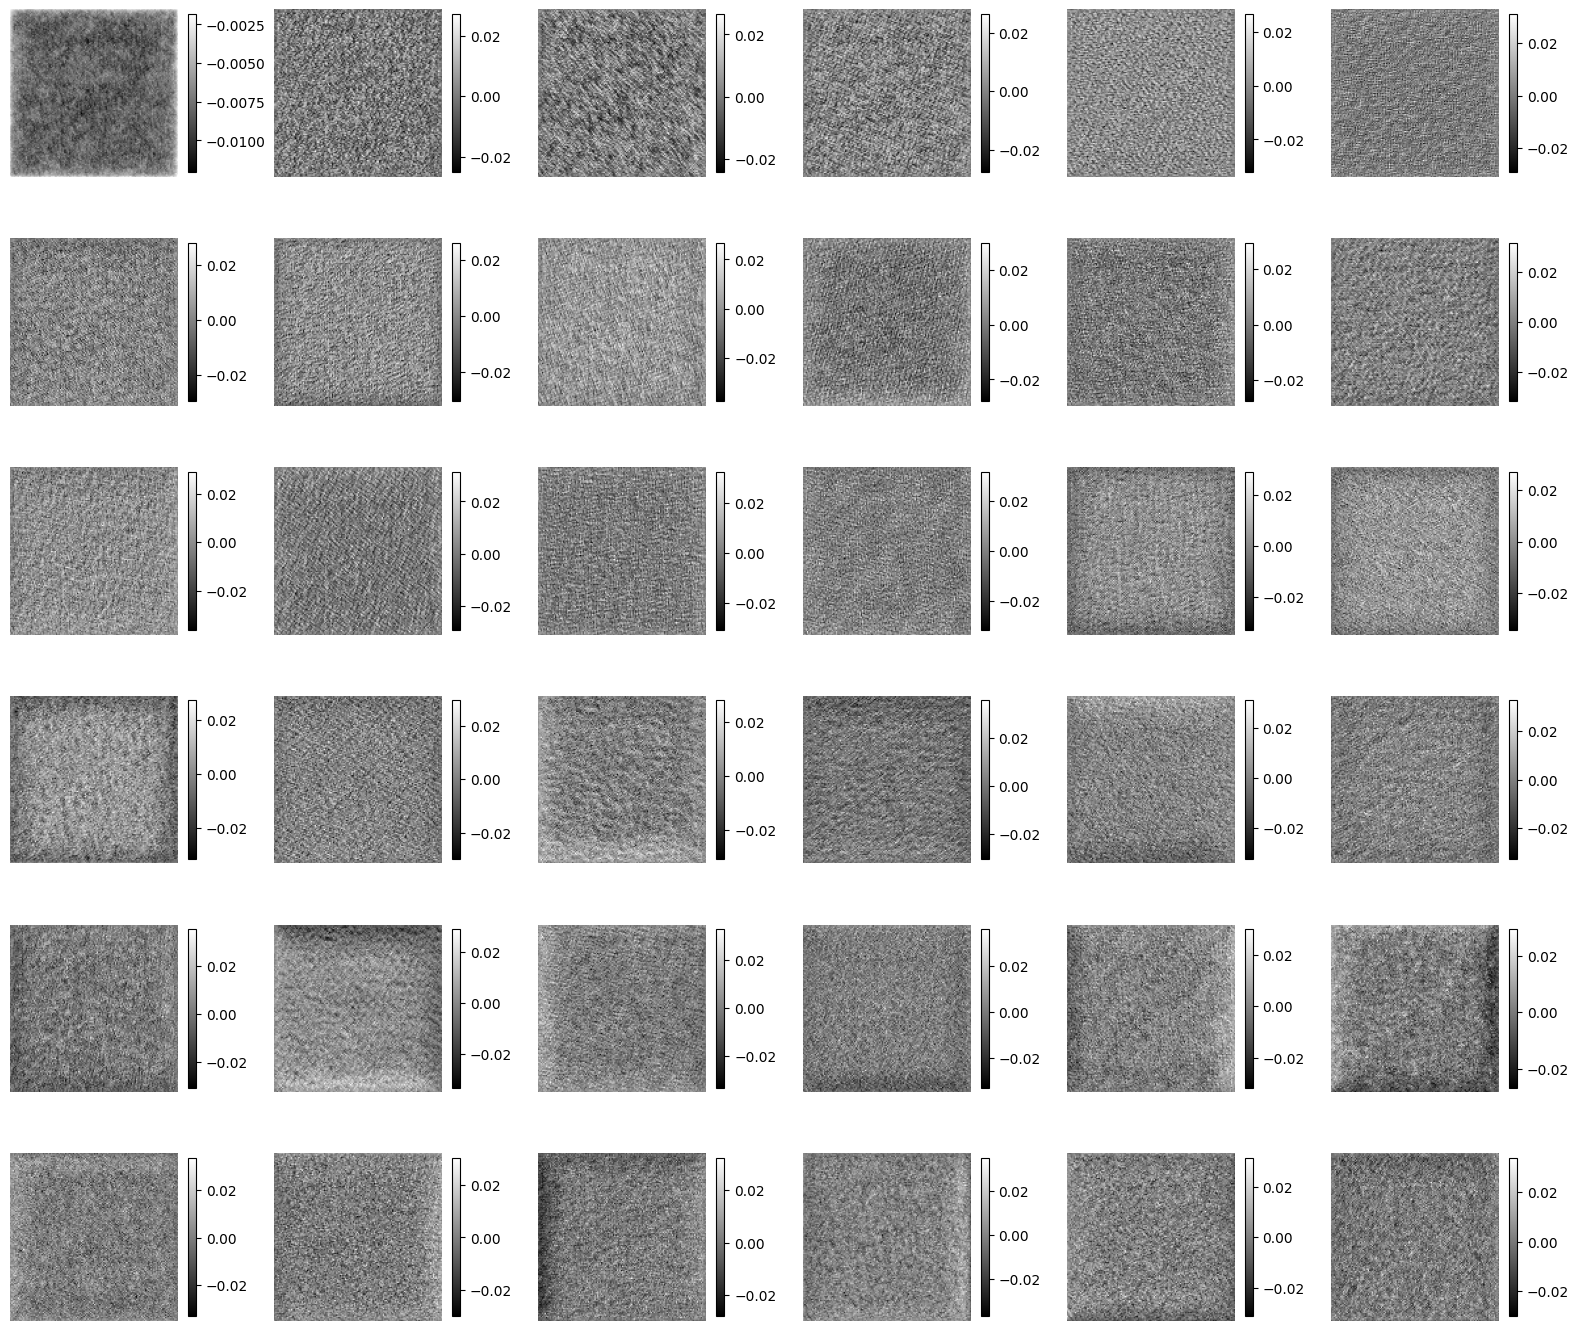

In [38]:
fig, axes = plt.subplots(6,6, figsize=(16,14))

for idx, ax in enumerate(axes.ravel()):
    if idx < U_B.shape[0]:
        im = ax.imshow(U_approx[:,idx].reshape(128,128).detach().cpu().numpy(), cmap="gray")
        fig.colorbar(im, ax=ax, shrink=0.7)
    ax.axis("off")
fig.tight_layout()
plt.show()

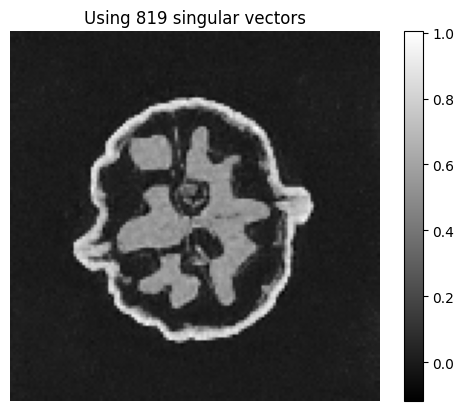

In [333]:
# can we represent x using the (left) singular vectors? 

rel_errors = []

x_svd = 0 
for i in range(U_approx.shape[1]):
    x_svd += torch.dot(x.ravel(), U_approx[:,i]) * U_approx[:,i]

    rel_errors.append((torch.sum((x.ravel() - x_svd)**2)/torch.sum(x**2)).item())
    #plt.figure()
    #plt.title(f"Using {i+1} singular vectors")
    #plt.imshow(x_svd.reshape(128,128).detach().cpu().numpy(), cmap="gray")
    #plt.colorbar()
    #plt.axis("off")
    #plt.show()

plt.figure()
plt.title(f"Using {U_approx.shape[1]} singular vectors")
plt.imshow(x_svd.reshape(128,128).detach().cpu().numpy(), cmap="gray")
plt.colorbar()
plt.axis("off")
plt.show()

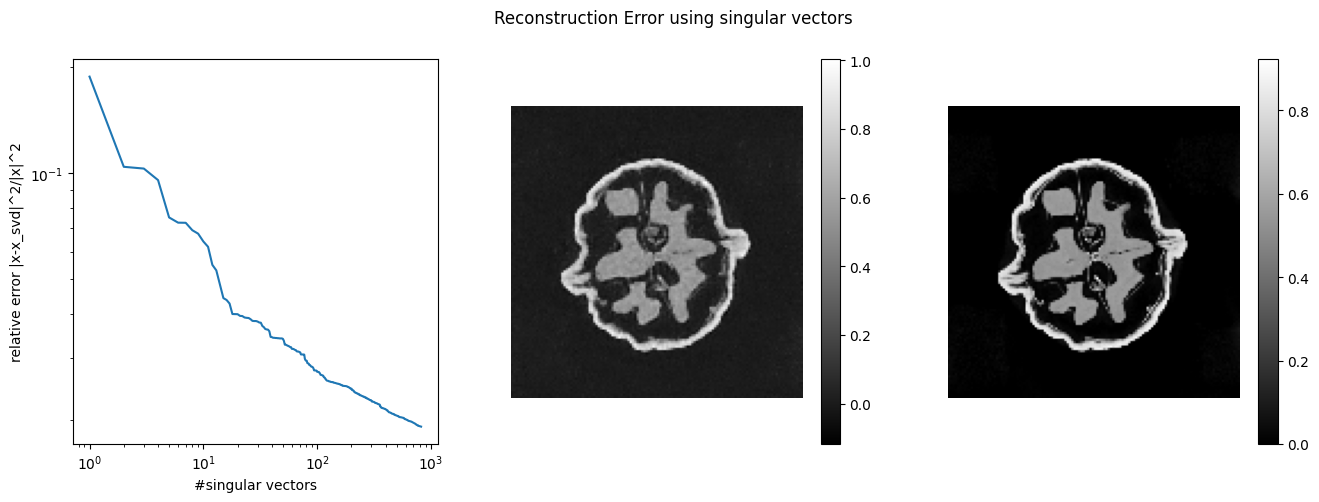

In [334]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

fig.suptitle("Reconstruction Error using singular vectors")
ax1.loglog(np.arange(1, len(rel_errors)+1), rel_errors)
ax1.set_xlabel("#singular vectors")
ax1.set_ylabel("relative error |x-x_svd|^2/|x|^2")

im = ax2.imshow(x_svd.reshape(128,128).detach().cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax2)
ax2.axis("off")

im = ax3.imshow(x[0,0].detach().cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax3)
ax3.axis("off")

plt.show()

In [335]:
rel_errors[-1]

0.019107893109321594

In [336]:
K_approx = U_approx @ torch.diag(S_B) @ U_approx.T

In [337]:
#torch.linalg.norm(K_approx, ord=2)**2

In [338]:
S_B[0]**2

tensor(1.7785e+11, device='cuda:1')

In [339]:
def compute_norm(physics, K, x0, max_iter=100, tol=1e-3, verbose=True):

    x = torch.randn_like(x0)
    x /= torch.norm(x)
    zold = torch.zeros_like(x)
    for it in range(max_iter):
        y = physics.A(x)
        y = physics.A_adjoint(y)
        y = K @ y.ravel()
        y = y.reshape(x.shape)
        z = torch.matmul(x.conj().reshape(-1), y.reshape(-1)) / torch.norm(x) ** 2

        rel_var = torch.norm(z - zold)
        if rel_var < tol and verbose:
            print(
                f"Power iteration converged at iteration {it}, value={z.item():.2f}"
            )
            break
        zold = z
        x = y / torch.norm(y)

    return z.real

x0 = torch.rand_like(x)

L = compute_norm(A, K_approx, x0) 
print(L)

Power iteration converged at iteration 5, value=2729155840.00
tensor(2.7292e+09, device='cuda:1')


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1114/1500 [00:06<00:02, 172.40it/s]


Get PSNR = 26.5384dB


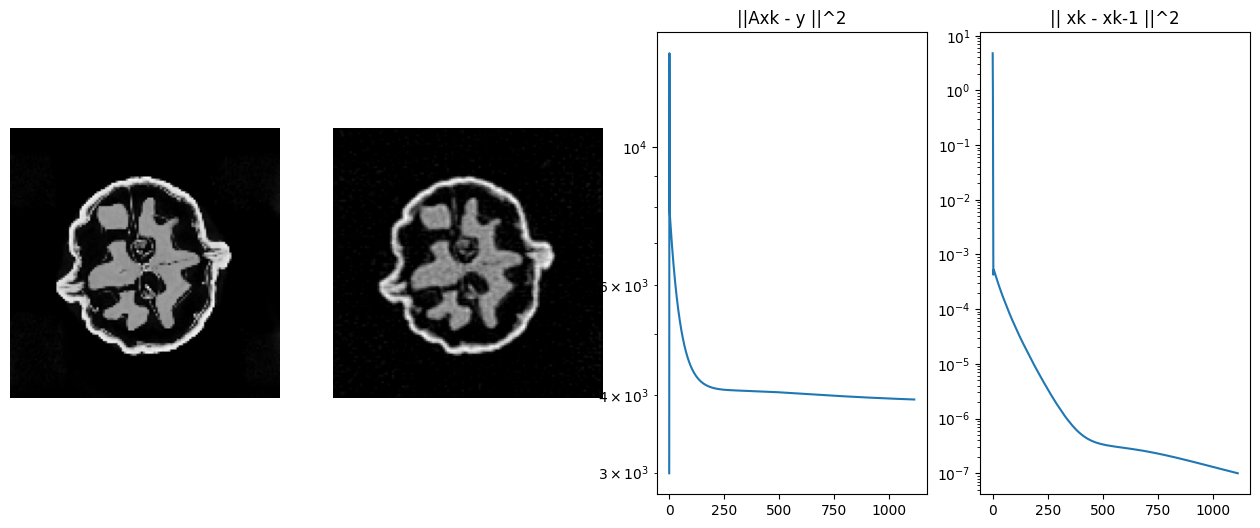

In [341]:
# gradient descent 



import deepinv as dinv 
from skimage.metrics import peak_signal_noise_ratio


max_iter = 1500
step_size = 1.0
tol = 1e-7

def GD_rec(y, physics, L, x_init, step_size, max_iter=2000, tol=1e-6):
    xk = torch.clone(x_init)
    x_prev = torch.clone(xk)

    res_list = [] 
    change_list = []
    for _ in tqdm(range(max_iter)):
        x_prev = xk 
        
        res = physics.A(xk)  - y_noise
        grad = physics.A_adjoint(res)
        precond_grad = K_approx @ grad.ravel()
        precond_grad = precond_grad.reshape(xk.shape)
        xk = xk - step_size/L * precond_grad
        xk[xk < 0] = 0.
        xk[xk > 1] = 1.

        
        res_list.append(torch.sum(res**2).item())
        change_list.append(torch.sum((xk - x_prev)**2).item())
        if torch.sum((xk - x_prev)**2).item() < tol:
            break
        
    return xk, res_list, change_list

with torch.no_grad():
    x_init = model(z) #torch.zeros_like(x)
x_rec, res_list, change_list = GD_rec(y_noise, A, L, x_init, step_size, max_iter=max_iter, tol=tol)

psnr = peak_signal_noise_ratio(x[0,0,:,:].cpu().numpy(), x_rec[0,0,:,:].detach().cpu().numpy())
print(f"Get PSNR = {psnr:.4f}dB")



fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,6))
ax1.imshow(x[0,0].cpu().numpy(), cmap="gray")
ax1.axis("off")
ax2.imshow(x_rec[0,0].cpu().numpy(), cmap="gray")
ax2.axis("off")
ax3.semilogy(res_list)
ax3.set_title("||Axk - y ||^2")
ax4.semilogy(change_list)
ax4.set_title("|| xk - xk-1 ||^2")
plt.show()

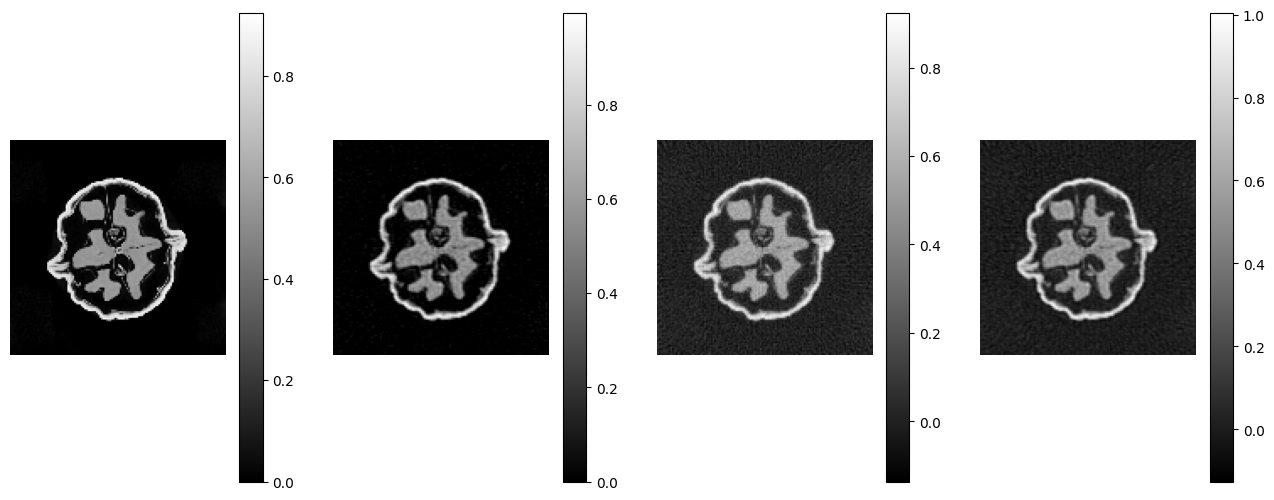

In [342]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,8))
im = ax1.imshow(x[0,0].cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax1, shrink=0.76)
ax1.axis("off")
im = ax2.imshow(x_rec[0,0].cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax2, shrink=0.76)
ax2.axis("off")
im = ax3.imshow(x_fbp[0,0].cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax3, shrink=0.76)
ax3.axis("off")
im = ax4.imshow(x_init[0,0].cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax4, shrink=0.76)
ax4.axis("off")
plt.show()

In [343]:
K_approx.shape

torch.Size([16384, 16384])

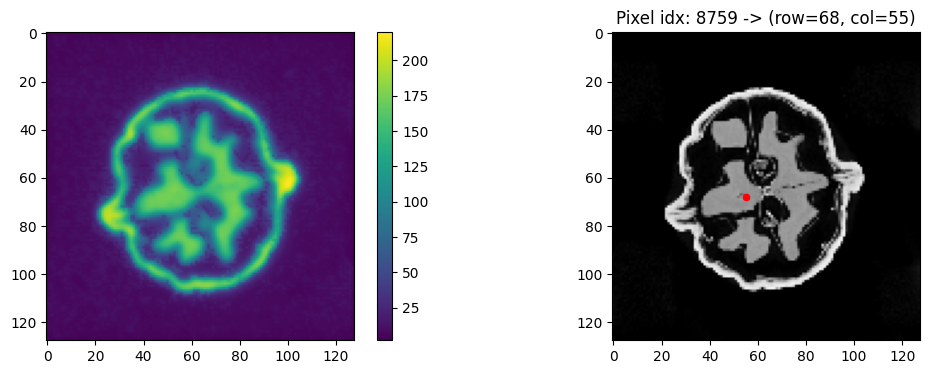

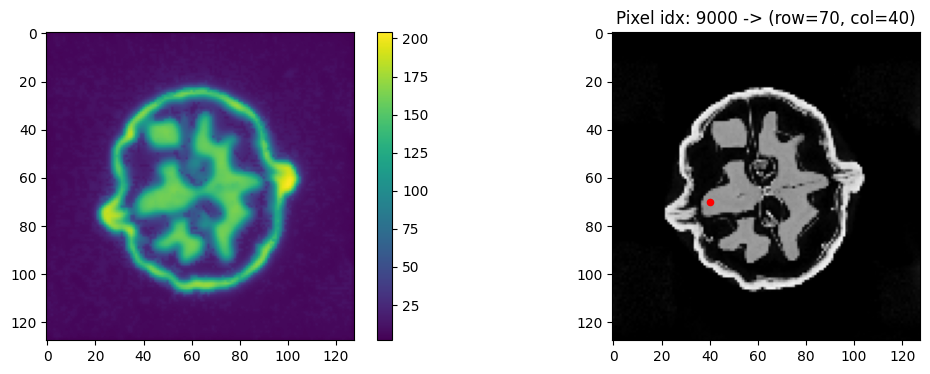

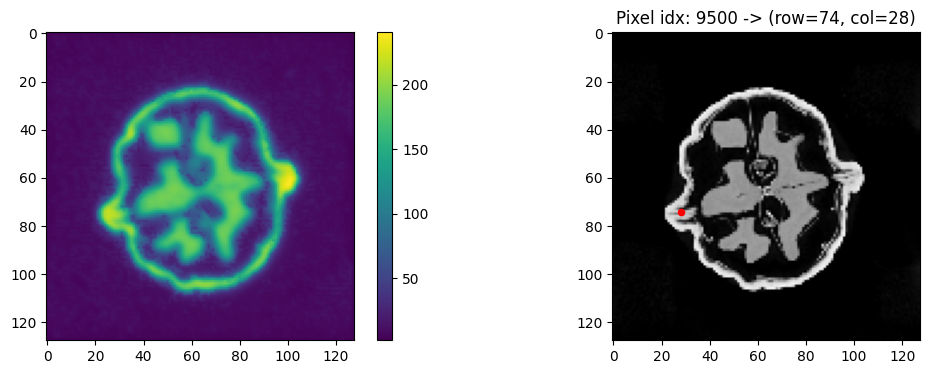

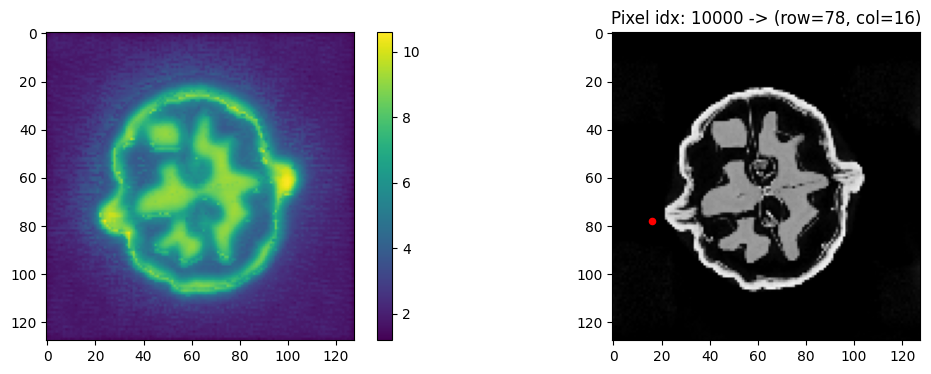

In [373]:
for idx in [8759, 9000, 9500, 10000]:
    
    fig, (ax1, ax2)= plt.subplots(1,2, figsize=(13,4))
    
    #idx = 8759
    row = idx // 128
    col = idx % 128
    
    im = ax1.imshow(K_approx[idx,:].reshape(128,128).cpu().numpy())
    fig.colorbar(im, ax=ax1)
    ax2.imshow(x[0,0].cpu().numpy(),cmap="gray")
    ax2.scatter([col], [row], color='red', s=20)  # mark the pixel
    ax2.set_title(f'Pixel idx: {idx} -> (row={row}, col={col})')
    
    
    plt.show()

Power iteration converged at iteration 10, value=11122.91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.78it/s]


Get PSNR = 28.0010dB


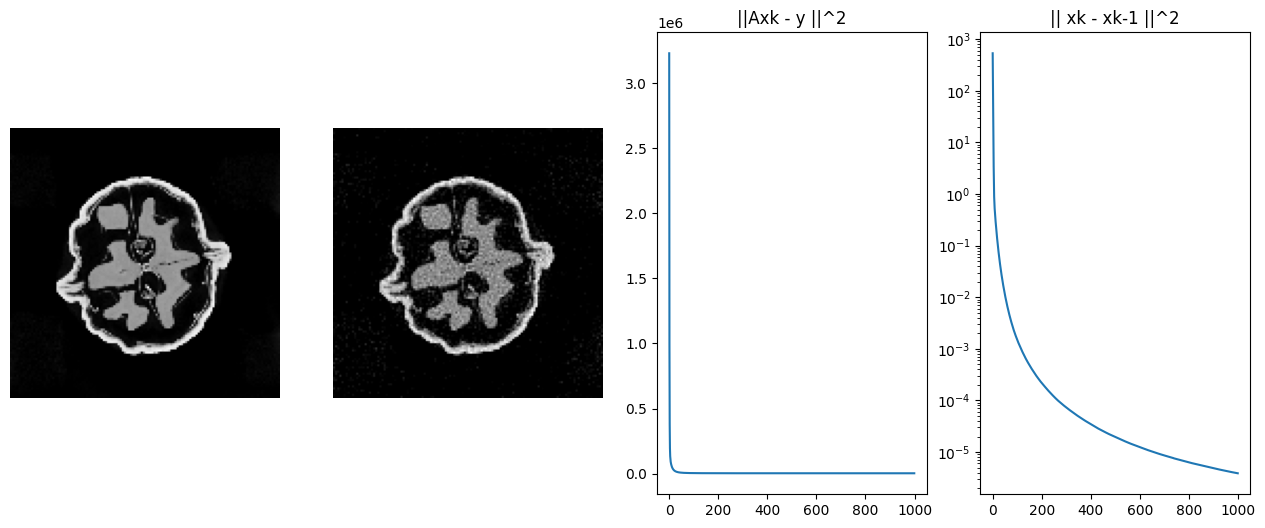

In [276]:
# gradient descent 



import deepinv as dinv 
from skimage.metrics import peak_signal_noise_ratio

L = A.operator.compute_norm(torch.rand_like(x))


max_iter = 1000
step_size =  1.5 
tol = 1e-6

def GD_rec(y, physics, L, x_init, step_size, alpha, max_iter=2000, tol=1e-6):
    xk = torch.clone(x_init)
    x_prev = torch.clone(xk)

    prior =  dinv.optim.prior.TVPrior(n_it_max=100)

    res_list = [] 
    change_list = []
    for _ in tqdm(range(max_iter)):
        x_prev = xk 
        
        res = physics.A(xk)  - y_noise
        grad = physics.A_adjoint(res)
        xk = xk - step_size/L * grad
        xk[xk < 0] = 0.
        xk[xk > 1] = 1.

        
        res_list.append(torch.sum(res**2).item())
        change_list.append(torch.sum((xk - x_prev)**2).item())
        if torch.sum((xk import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4_b = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)  # concat with conv3 output
        self.upconv2 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)  # concat with conv2 output
        self.upconv3 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)  # concat with conv1 output
        self.final_conv = nn.Conv2d(128, 3, kernel_size=1)  # final RGB output

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Encoder
        x1 = self.relu(self.conv1(x))  # convd1 + relu1
        x1_down = F.interpolate(x1, scale_factor=0.5, mode='bilinear', align_corners=False)  # down1

        x2 = self.relu(self.conv2(x1_down))  # convd2 + relu2
        x2_down = F.interpolate(x2, scale_factor=0.5, mode='bilinear', align_corners=False)  # down2

        x3 = self.relu(self.conv3(x2_down))  # convd3 + relu3
        x3_down = F.interpolate(x3, scale_factor=0.5, mode='bilinear', align_corners=False)  # down3

        x4 = self.relu(self.conv4(x3_down))  # convd4 + relu4
        x4 = self.relu(self.conv4_b(x4))     # conv4

        # Decoder
        x_up1 = F.interpolate(x4, scale_factor=2.0, mode='bilinear', align_corners=False)  # up1
        x_up1 = self.relu(self.upconv1(torch.cat([x_up1, x3], dim=1)))  # skip connection from x3

        x_up2 = F.interpolate(x_up1, scale_factor=2.0, mode='bilinear', align_corners=False)  # up2
        x_up2 = self.relu(self.upconv2(torch.cat([x_up2, x2], dim=1)))  # skip connection from x2

        x_up3 = F.interpolate(x_up2, scale_factor=2.0, mode='bilinear', align_corners=False)  # up3
        x_up3 = self.relu(self.upconv3(torch.cat([x_up3, x1], dim=1)))  # skip connection from x1

        out = self.final_conv(x_up3)  # convu4
        return out- x_prev)**2).item() < tol:
            break
        
    return xk, res_list, change_list


x_init = torch.zeros_like(x)
x_rec, res_list, change_list = GD_rec(y_noise, A, L, x_init, step_size, alpha, max_iter=max_iter, tol=tol)

psnr = peak_signal_noise_ratio(x[0,0,:,:].cpu().numpy(), x_rec[0,0,:,:].detach().cpu().numpy())
print(f"Get PSNR = {psnr:.4f}dB")



fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,6))
ax1.imshow(x[0,0].cpu().numpy(), cmap="gray")
ax1.axis("off")
ax2.imshow(x_rec[0,0].cpu().numpy(), cmap="gray")
ax2.axis("off")
ax3.plot(res_list)
ax3.set_title("||Axk - y ||^2")
ax4.semilogy(change_list)
ax4.set_title("|| xk - xk-1 ||^2")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]

Get PSNR = 12.4107dB


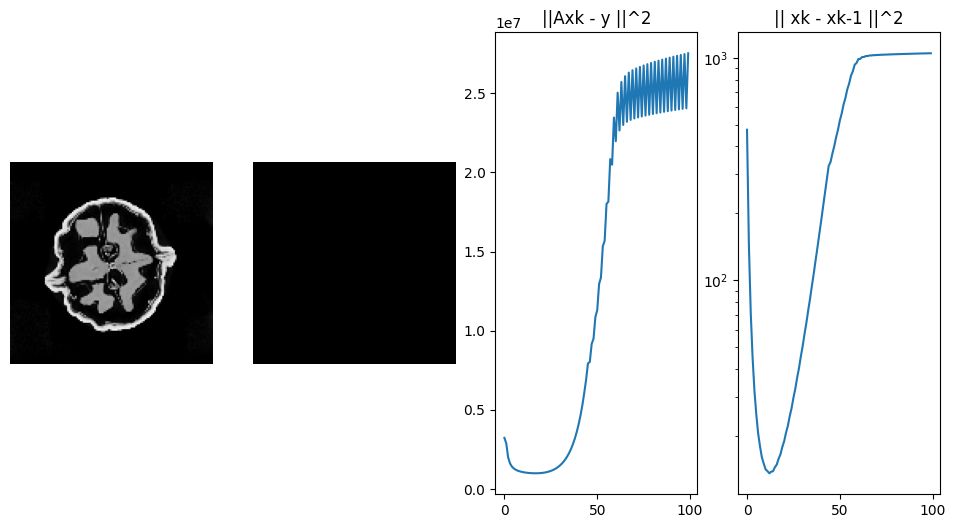

In [46]:


import deepinv as dinv 
from skimage.metrics import peak_signal_noise_ratio




max_iter = 100
step_size =  1.5 
tol = 1e-6

def TV_rec(y, physics, L, x_init, step_size, alpha, max_iter=2000, tol=1e-6):
    xk = torch.clone(x_init)
    x_prev = torch.clone(xk)

    prior =  dinv.optim.prior.TVPrior(n_it_max=100)

    # FISTA
    tk = torch.tensor(1.0)

    res_list = [] 
    change_list = []
    for _ in tqdm(range(max_iter)):
        tk_new = (1 + torch.sqrt(1 + 4 * tk**2))/2
        ak = (tk -1) / tk_new

        xk_tilde = xk + ak * (xk - x_prev)

        res = physics.A(xk_tilde)  - y_noise
        grad = physics.A_adjoint(res)
        precond_grad = K_approx @ grad.ravel()
        precond_grad = precond_grad.reshape(xk_tilde.shape)
        x_next = xk_tilde - step_size/L * precond_grad
        x_next = prior.prox(x_next, gamma=step_size/L*alpha)
        x_next[x_next < 0] = 0.
        x_next[x_next > 1] = 1.

        x_prev = xk 
        xk = x_next
        tk = tk_new
        res_list.append(torch.sum(res**2).item())
        change_list.append(torch.sum((xk - x_prev)**2).item())
        if torch.sum((xk - x_prev)**2).item() < tol:
            break
        
    return xk, res_list, change_list




alpha = 0.1
x_init = torch.zeros_like(x)
x_rec, res_list, change_list = TV_rec(y_noise, A, L, x_init, step_size, alpha, max_iter=max_iter, tol=tol)

psnr = peak_signal_noise_ratio(x[0,0,:,:].cpu().numpy(), x_rec[0,0,:,:].detach().cpu().numpy())
print(f"Get PSNR = {psnr:.4f}dB")



fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,6))
ax1.imshow(x[0,0].cpu().numpy(), cmap="gray")
ax1.axis("off")
ax2.imshow(x_rec[0,0].cpu().numpy(), cmap="gray")
ax2.axis("off")
ax3.plot(res_list)
ax3.set_title("||Axk - y ||^2")
ax4.semilogy(change_list)
ax4.set_title("|| xk - xk-1 ||^2")
plt.show()

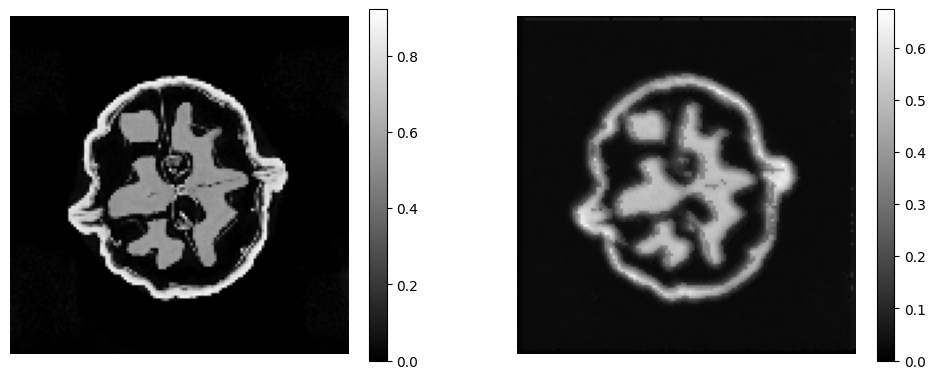

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
im = ax1.imshow(x[0,0].cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax1, shrink=0.76)
ax1.axis("off")
im = ax2.imshow(x_rec[0,0].cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax2, shrink=0.76)
ax2.axis("off")
plt.show()